In [78]:
from os.path import join

import csiborgtools
import healpy
import matplotlib.pyplot as plt
import numpy
import scienceplots  # noqa
from cache_to_disk import cache_to_disk, delete_disk_caches_for_function
from h5py import File

import plt_utils


sim2boxsize = {"csiborg" : 677.7,
               "csiborg2_main": 676.7,
               "BORG": 677.7,
               }


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
with File("/mnt/zfsusers/hdesmond/BORG_final/mcmc_9844.h5", 'r') as f:
    d = f["scalars/BORG_final_density"][:]

In [92]:
d.min()

-1.0

In [127]:


@cache_to_disk(30)
def _plot_sky_projected_density(nsim, simname, grid, nside, MAS="PCS",
                                dmin=0, dmax=220, volume_weight=True):
    paths = csiborgtools.read.Paths(**csiborgtools.paths_glamdring)
    # nsnap = max(paths.get_snapshots(nsim, simname))
    # Some work here to get the box
    boxsize = sim2boxsize[simname]

    if simname == "csiborg":
        field = numpy.load(paths.field("density", MAS, grid, nsim, in_rsp=False))
    elif simname == "BORG":
        with File("/mnt/zfsusers/hdesmond/BORG_final/mcmc_9844.h5", 'r') as f:
            field = f["scalars/BORG_final_density"][:]
            field = field.astype(numpy.float32)
            # field = field.T
            field += 1
    else:
        with File("/mnt/extraspace/rstiskalek/csiborg2_main/fields/chain_15517_1024.hdf5", 'r') as f:
            field = f["density"][:].T

    # field /= numpy.mean(field)
    # field += 1

    angpos = csiborgtools.field.nside2radec(nside)
    dist = numpy.linspace(dmin, dmax, 1000)
    return csiborgtools.field.make_sky(field, angpos=angpos, dist=dist,
                                       boxsize=boxsize, volume_weight=volume_weight)

In [135]:
def plot_sky_projected_density(nsim, simname, grid, nside, MAS="PCS",
                               dmin=0, dmax=220, volume_weight=True, ext="png",
                               to_save=False):
    dmap = _plot_sky_projected_density(nsim, simname, grid, nside, MAS,
                                           dmin, dmax, volume_weight)
    obs = numpy.genfromtxt("/mnt/zfsusers/rstiskalek/csiborgtools/data/2MPP.txt")
    
    dist = obs[:, 6] * 3e5 / 100
    
    mask = (dist > dmin) & (dist < dmax)
    obs = obs[mask]

    print(obs[:, 2].min(), obs[:, 2].max())

    with plt.style.context(plt_utils.mplstyle):
        healpy.mollview(numpy.log10(dmap), fig=0, title="", unit="", rot=75)

        healpy.projscatter(numpy.pi / 2 - obs[:, 2], obs[:, 1], s=0.05, c="red",
                           label="2M++ galaxies")
        
        # for name in ["Virgo", "Fornax"]:
        #     d, ra, dec = csiborgtools.clusters[name].spherical_pos
        #     ra *= numpy.pi / 180
        #     dec *= numpy.pi / 180
        #     healpy.projscatter([numpy.pi / 2 - dec], [ra], s=30, c="black", marker='x')
        # healpy.projscatter(obs[:, 2] - numpy.pi / 2, obs[:, 1], s=0.25, c="red",
                        #    label="2M++ galaxies")
        # healpy.projscatter(obs[:, 2] - numpy.pi / 2 , obs[:, 1], s=1, c="red",
                        #    label="2M++ galaxies")

        # if plot_groups:
        #     groups = csiborgtools.read.TwoMPPGroups(fpath="/mnt/extraspace/rstiskalek/catalogs/2M++_group_catalog.dat")  # noqa
        #     healpy.projscatter(numpy.deg2rad(groups["DEC"] + 90),
        #                        numpy.deg2rad(groups["RA"]), s=1, c="blue",
        #                        label="2M++ groups")

        # if plot_halos is not None or plot_groups:
        #     plt.legend(markerscale=5)

        if to_save:
            # fout = join(plt_utils.fout, f"sky_density_{simname}_{nsim}_from_{dmin}_to_{dmax}_vol{volume_weight}.{ext}")  # noqa
            fout = "test.png"
            print(f"Saving to `{fout}`.")
            plt.savefig(fout, dpi=plt_utils.dpi, bbox_inches="tight")
        plt.show()

100%|██████████| 3145728/3145728 [06:06<00:00, 8572.34it/s]


-1.50601 1.48367
Saving to `test.png`.


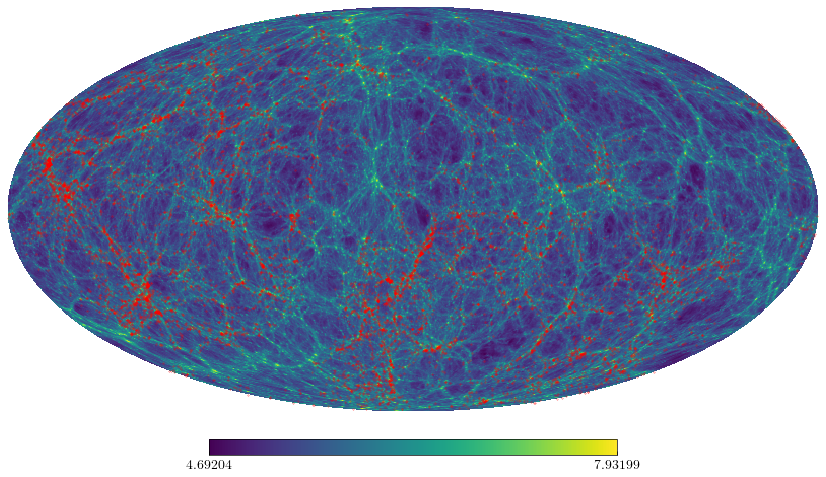

In [140]:
# delete_disk_caches_for_function("_plot_sky_projected_density")
plot_sky_projected_density(15517, "csiborg2_main", 512, 512, "PCS", dmin=100,
                           dmax=125, volume_weight=True, to_save=True)
# plt.savefig("test.png", dpi=300)